In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
from torchmodel import UNet
from root_dataset import Train_dataset, Test_dataset
import albumentations as albu
import segmentation_models_pytorch as smp
import random
import numpy as np
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

/opt/homebrew/Caskroom/miniconda/base/envs/ptch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
height = 512

In [4]:
def get_train_augmentation(height):
    trainaugmentation = albu.Compose([
        albu.Resize(height,height),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=0.5),
        albu.Transpose(p=0.5),
        albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        albu.GridDistortion(p=0.5),
        albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        albu.RandomBrightnessContrast(p=0.5),
        albu.RandomGamma(p=0.5),
        albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
        albu.GaussNoise(),
        albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
        #albu.Lambda(image=lambda x,**kwargs: x/255),
    ])
    return trainaugmentation

In [5]:
def get_val_augmentation(height):
    trainaugmentation = albu.Compose([
        albu.Resize(height,height),
        # albu.Lambda(image=lambda x,**kwargs: x/255),
    ])
    return trainaugmentation

In [6]:
train_aug = get_train_augmentation(height)
val_aug = get_val_augmentation(height)

In [7]:
train = Train_dataset(height,train_aug,'crosval/train','castom-masks/masks_machine',device)
val = Train_dataset(height,val_aug,'crosval/val','castom-masks/masks_machine',device)

['AAE_0196.png', 'AAE_0182.png', 'AAE_0021.png', 'AAE_0236.png', 'AAE_0140.png', 'AAE_0154.png', 'AAE_0181.png', 'AAE_0156.png', 'AAE_0036.png', 'AAE_0022.png', 'AAE_0209.png', 'AAE_0180.png', 'AAE_0184.png', 'AAE_0190.png', 'AAE_0147.png', 'AAE_0027.png', 'AAE_0218.png', 'AAE_0146.png', 'AAE_0185.png', 'AAE_0193.png', 'AAE_0150.png', 'AAE_0226.png', 'AAE_0233.png', 'AAE_0019.png', 'AAE_0025.png', 'AAE_0179.png', 'AAE_0145.png', 'AAE_0192.png', 'AAE_0136.png', 'AAE_0057.png', 'AAE_0080.png', 'AAE_0041.png', 'AAE_0040.png', 'AAE_0068.png', 'AAE_0083.png', 'AAE_0097.png', 'AAE_0124.png', 'AAE_0087.png', 'AAE_0045.png', 'AAE_0119.png', 'AAE_0125.png', 'AAE_0127.png', 'AAE_0047.png', 'AAE_0085.png', 'AAE_0117.png', 'AAE_0063.png', 'AAE_0076.png', 'AAE_0062.png', 'AAE_0089.png', 'AAE_0116.png', 'AAE_0100.png', 'AAE_0114.png', 'AAE_0048.png', 'AAE_0101.png', 'AAE_0071.png', 'AAE_0058.png', 'AAE_0070.png', 'AAE_0073.png', 'AAE_0098.png', 'AAE_0107.png', 'AAE_0174.png', 'AAE_0028.png', 'AAE_00

<Figure size 640x480 with 0 Axes>

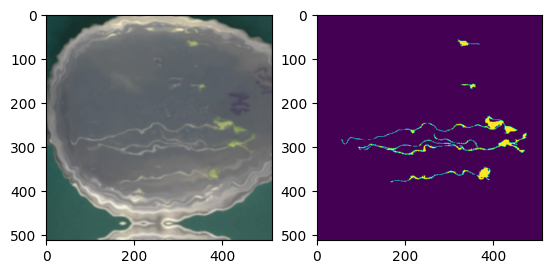

In [8]:
plt.figure()
f, axarr = plt.subplots(1,2) 
image,mask = train.__getitem__(0)
axarr[0].imshow(image.permute(1,2,0).cpu())
axarr[1].imshow(mask.permute(1,2,0).cpu())

In [9]:
model = UNet(3,1)

In [10]:
train_loader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=False)

In [11]:
focal_loss = smp.losses.FocalLoss('binary')
iou_loss = smp.losses.JaccardLoss('binary')
dice_loss = smp.losses.DiceLoss('binary')
bce_loss = smp.losses.SoftBCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),0.001,amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=5,verbose=True)

In [12]:
def loss_f(outputs, targets):
    return focal_loss(outputs, targets) * 0.2 + iou_loss(outputs, targets) * 0.2 + dice_loss(outputs, targets) * 0.4 + bce_loss(outputs,targets) * 0.2

In [13]:
def metric(outputs, targets):
    return 1 - dice_loss(outputs, targets)

In [14]:
epochs = 100
patience = 20
model_path =  'models/best-model.pt'

In [15]:
model.to(device)
best_loss = 100
counter = 0
for epoch in range(epochs):
    train_loss = 0.0
    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_f(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    val_loss = 0.0

    model.eval()
    for inputs, targets in tqdm(val_loader):
        model.eval()
        outputs = model(inputs)
            
            # Calculate loss
        loss = loss_f(outputs, targets)
        val_loss += loss.item()

    val_loss /= len(val_loader)

    scheduler.step(val_loss)

    improve = False

    if val_loss < best_loss: 
        best_loss = val_loss
        improve = True
        print('model saved')
        torch.save(model,model_path)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Dice: {metric(outputs, targets):.4f} | Val Dice: {metric(outputs, targets):.4f}")

    if not improve:
        counter += 1
        if counter > patience:
            print('early stop')
            break
    else:
        counter = 0
        

100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [1/100] | Train Loss: 0.8447 | Val Loss: 0.8448 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [2/100] | Train Loss: 0.8256 | Val Loss: 0.8221 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [3/100] | Train Loss: 0.8166 | Val Loss: 0.8114 | Train Dice: 0.0094 | Val Dice: 0.0094


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [4/100] | Train Loss: 0.8094 | Val Loss: 0.8105 | Train Dice: 0.0094 | Val Dice: 0.0094


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [5/100] | Train Loss: 0.8037 | Val Loss: 0.8038 | Train Dice: 0.0094 | Val Dice: 0.0094


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [6/100] | Train Loss: 0.8002 | Val Loss: 0.8015 | Train Dice: 0.0094 | Val Dice: 0.0094


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [7/100] | Train Loss: 0.7950 | Val Loss: 0.7941 | Train Dice: 0.0095 | Val Dice: 0.0095


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [8/100] | Train Loss: 0.7904 | Val Loss: 0.7870 | Train Dice: 0.0095 | Val Dice: 0.0095


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [9/100] | Train Loss: 0.7878 | Val Loss: 0.7833 | Train Dice: 0.0095 | Val Dice: 0.0095


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [10/100] | Train Loss: 0.7848 | Val Loss: 0.7810 | Train Dice: 0.0095 | Val Dice: 0.0095


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [11/100] | Train Loss: 0.7830 | Val Loss: 0.7799 | Train Dice: 0.0095 | Val Dice: 0.0095


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [12/100] | Train Loss: 0.7806 | Val Loss: 0.7782 | Train Dice: 0.0095 | Val Dice: 0.0095


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [13/100] | Train Loss: 0.7788 | Val Loss: 0.7770 | Train Dice: 0.0095 | Val Dice: 0.0095


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Epoch [14/100] | Train Loss: 0.7781 | Val Loss: 0.7788 | Train Dice: 0.0094 | Val Dice: 0.0094


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [15/100] | Train Loss: 0.7771 | Val Loss: 0.7763 | Train Dice: 0.0094 | Val Dice: 0.0094


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [16/100] | Train Loss: 0.7752 | Val Loss: 0.7735 | Train Dice: 0.0094 | Val Dice: 0.0094


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [17/100] | Train Loss: 0.7741 | Val Loss: 0.7717 | Train Dice: 0.0094 | Val Dice: 0.0094


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Epoch [18/100] | Train Loss: 0.7730 | Val Loss: 0.7723 | Train Dice: 0.0094 | Val Dice: 0.0094


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [19/100] | Train Loss: 0.7730 | Val Loss: 0.7708 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [20/100] | Train Loss: 0.7715 | Val Loss: 0.7693 | Train Dice: 0.0094 | Val Dice: 0.0094


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [21/100] | Train Loss: 0.7706 | Val Loss: 0.7687 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [22/100] | Train Loss: 0.7703 | Val Loss: 0.7683 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [23/100] | Train Loss: 0.7696 | Val Loss: 0.7678 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [24/100] | Train Loss: 0.7694 | Val Loss: 0.7675 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [25/100] | Train Loss: 0.7693 | Val Loss: 0.7670 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [26/100] | Train Loss: 0.7689 | Val Loss: 0.7668 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [27/100] | Train Loss: 0.7685 | Val Loss: 0.7664 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [28/100] | Train Loss: 0.7677 | Val Loss: 0.7661 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [29/100] | Train Loss: 0.7679 | Val Loss: 0.7661 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [30/100] | Train Loss: 0.7678 | Val Loss: 0.7659 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [31/100] | Train Loss: 0.7674 | Val Loss: 0.7657 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [32/100] | Train Loss: 0.7670 | Val Loss: 0.7657 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [33/100] | Train Loss: 0.7674 | Val Loss: 0.7653 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [34/100] | Train Loss: 0.7670 | Val Loss: 0.7653 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [35/100] | Train Loss: 0.7672 | Val Loss: 0.7652 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Epoch [36/100] | Train Loss: 0.7666 | Val Loss: 0.7652 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [37/100] | Train Loss: 0.7667 | Val Loss: 0.7650 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [38/100] | Train Loss: 0.7668 | Val Loss: 0.7649 | Train Dice: 0.0093 | Val Dice: 0.0093


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Epoch [39/100] | Train Loss: 0.7668 | Val Loss: 0.7649 | Train Dice: 0.0094 | Val Dice: 0.0094


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [40/100] | Train Loss: 0.7665 | Val Loss: 0.7647 | Train Dice: 0.0094 | Val Dice: 0.0094


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [41/100] | Train Loss: 0.7664 | Val Loss: 0.7646 | Train Dice: 0.0094 | Val Dice: 0.0094


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


model saved
Epoch [42/100] | Train Loss: 0.7666 | Val Loss: 0.7644 | Train Dice: 0.0094 | Val Dice: 0.0094


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [43/100] | Train Loss: 0.7666 | Val Loss: 0.7644 | Train Dice: 0.0096 | Val Dice: 0.0096


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Epoch [44/100] | Train Loss: 0.7663 | Val Loss: 0.7645 | Train Dice: 0.0095 | Val Dice: 0.0095


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [45/100] | Train Loss: 0.7663 | Val Loss: 0.7642 | Train Dice: 0.0096 | Val Dice: 0.0096


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [46/100] | Train Loss: 0.7663 | Val Loss: 0.7640 | Train Dice: 0.0096 | Val Dice: 0.0096


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [47/100] | Train Loss: 0.7663 | Val Loss: 0.7639 | Train Dice: 0.0096 | Val Dice: 0.0096


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Epoch [48/100] | Train Loss: 0.7659 | Val Loss: 0.7641 | Train Dice: 0.0097 | Val Dice: 0.0097


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Epoch [49/100] | Train Loss: 0.7660 | Val Loss: 0.7640 | Train Dice: 0.0097 | Val Dice: 0.0097


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


model saved
Epoch [50/100] | Train Loss: 0.7657 | Val Loss: 0.7637 | Train Dice: 0.0097 | Val Dice: 0.0097


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [51/100] | Train Loss: 0.7656 | Val Loss: 0.7636 | Train Dice: 0.0098 | Val Dice: 0.0098


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Epoch [52/100] | Train Loss: 0.7656 | Val Loss: 0.7638 | Train Dice: 0.0100 | Val Dice: 0.0100


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Epoch [53/100] | Train Loss: 0.7655 | Val Loss: 0.7637 | Train Dice: 0.0097 | Val Dice: 0.0097


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Epoch [54/100] | Train Loss: 0.7661 | Val Loss: 0.7638 | Train Dice: 0.0096 | Val Dice: 0.0096


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [55/100] | Train Loss: 0.7658 | Val Loss: 0.7634 | Train Dice: 0.0097 | Val Dice: 0.0097


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [56/100] | Train Loss: 0.7656 | Val Loss: 0.7633 | Train Dice: 0.0100 | Val Dice: 0.0100


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [57/100] | Train Loss: 0.7654 | Val Loss: 0.7632 | Train Dice: 0.0100 | Val Dice: 0.0100


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Epoch [58/100] | Train Loss: 0.7657 | Val Loss: 0.7634 | Train Dice: 0.0098 | Val Dice: 0.0098


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [59/100] | Train Loss: 0.7655 | Val Loss: 0.7632 | Train Dice: 0.0099 | Val Dice: 0.0099


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [60/100] | Train Loss: 0.7652 | Val Loss: 0.7630 | Train Dice: 0.0102 | Val Dice: 0.0102


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Epoch [61/100] | Train Loss: 0.7651 | Val Loss: 0.7633 | Train Dice: 0.0099 | Val Dice: 0.0099


100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Epoch [62/100] | Train Loss: 0.7658 | Val Loss: 0.7633 | Train Dice: 0.0100 | Val Dice: 0.0100


100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


model saved
Epoch [63/100] | Train Loss: 0.7652 | Val Loss: 0.7628 | Train Dice: 0.0105 | Val Dice: 0.0105


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Epoch [64/100] | Train Loss: 0.7655 | Val Loss: 0.7632 | Train Dice: 0.0102 | Val Dice: 0.0102


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Epoch [65/100] | Train Loss: 0.7655 | Val Loss: 0.7628 | Train Dice: 0.0102 | Val Dice: 0.0102


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [66/100] | Train Loss: 0.7651 | Val Loss: 0.7627 | Train Dice: 0.0101 | Val Dice: 0.0101


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Epoch [67/100] | Train Loss: 0.7652 | Val Loss: 0.7628 | Train Dice: 0.0102 | Val Dice: 0.0102


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [68/100] | Train Loss: 0.7651 | Val Loss: 0.7626 | Train Dice: 0.0102 | Val Dice: 0.0102


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [69/100] | Train Loss: 0.7652 | Val Loss: 0.7623 | Train Dice: 0.0103 | Val Dice: 0.0103


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Epoch [70/100] | Train Loss: 0.7647 | Val Loss: 0.7626 | Train Dice: 0.0100 | Val Dice: 0.0100


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [71/100] | Train Loss: 0.7647 | Val Loss: 0.7622 | Train Dice: 0.0104 | Val Dice: 0.0104


100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


model saved
Epoch [72/100] | Train Loss: 0.7648 | Val Loss: 0.7620 | Train Dice: 0.0105 | Val Dice: 0.0105


 50%|█████     | 4/8 [00:21<00:21,  5.27s/it]


KeyboardInterrupt: 

Epoch [61/100] | Train Loss: 0.8235 | Val Loss: 0.8208

In [15]:
model = torch.load(model_path)

Epoch [10/10] | Train Loss: 4.1113 | Val Loss: 3.9804

In [20]:
test = Test_dataset(val_aug,'crosval/test',device)

['AAE_0223.png', 'AAE_0237.png', 'AAE_0221.png', 'AAE_0023.png', 'AAE_0086.png', 'AAE_0074.png', 'AAE_0138.png', 'AAE_0160.png', 'AAE_0172.png', 'AAE_0205.png']


In [21]:
test_loader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

In [23]:
for inputs in tqdm(test_loader):
    model.eval()
    outputs = model(inputs)

100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


In [24]:
outputs.shape

torch.Size([10, 1, 512, 512])

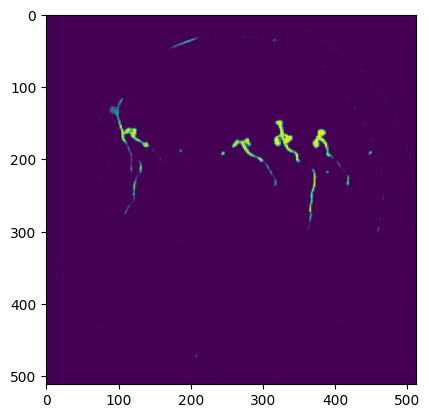

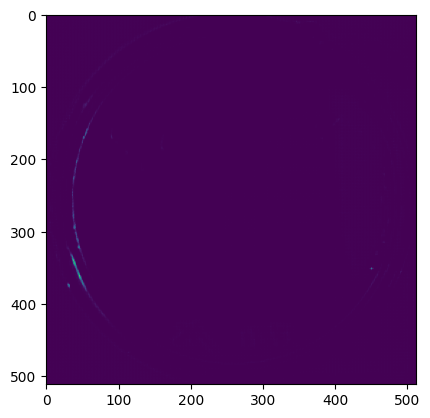

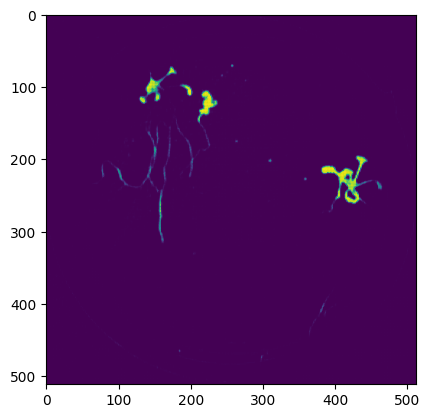

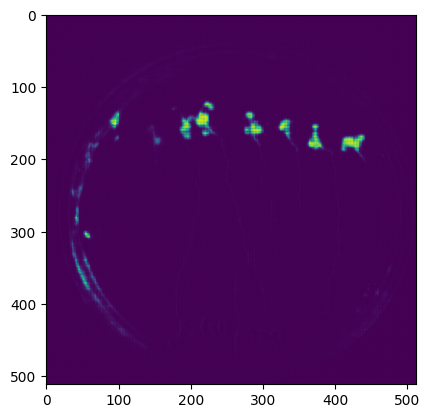

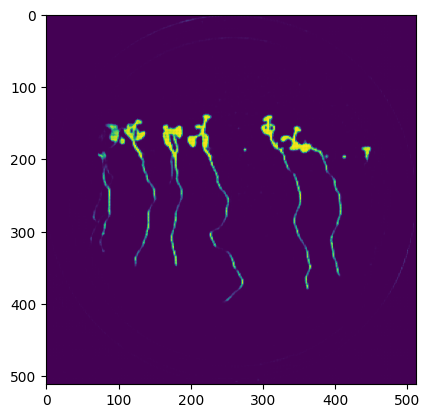

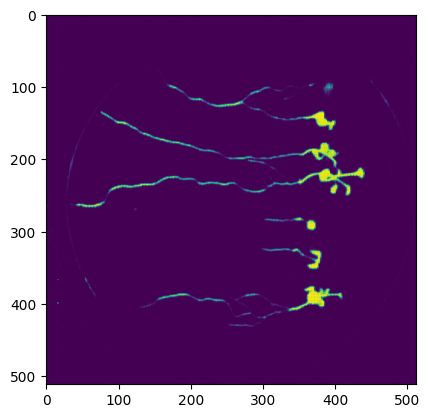

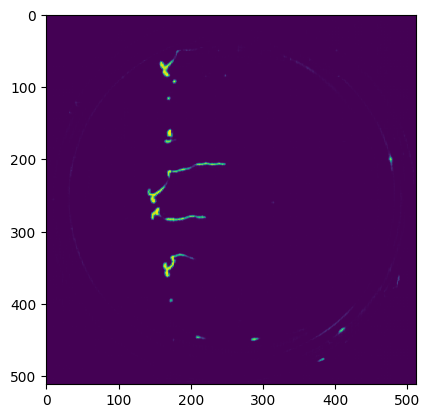

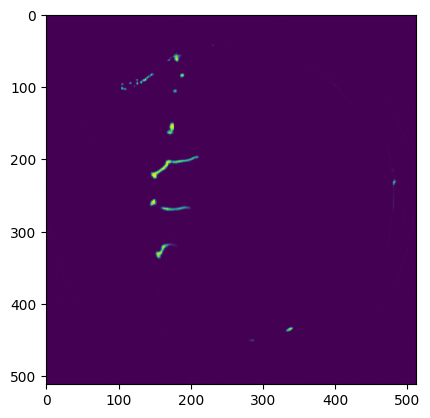

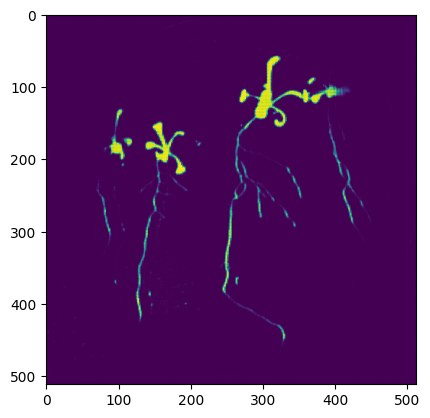

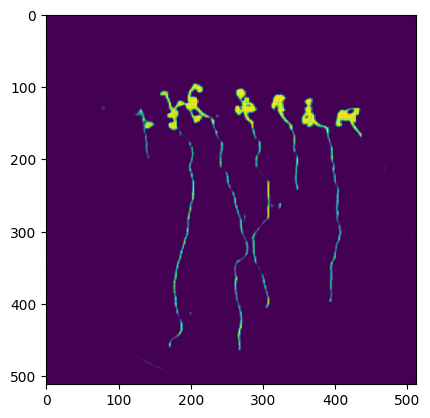

In [25]:
for i in outputs:
    i.reshape(1, height, height)
    plt.imshow(i.cpu().permute(1,2,0).detach().numpy())
    plt.pause(1)